In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from jax import vmap, jit
from fastprogress import progress_bar
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

from bayes_ca import prox_grad
import bayes_ca.inference as core

In [2]:
@jit
def gibbs_sample_subject_means(key,
                         subj_obs, 
                         sigmasq_obs, 
                         global_means, 
                         sigmasq_subj, 
                         mu_pri, 
                         sigmasq_pri, 
                         hazard_rates):
    num_subjects = subj_obs.shape[0]
    effective_sigmasq = 1 / (1 / sigmasq_obs + 1 / sigmasq_subj)
    effective_emissions = effective_sigmasq * (subj_obs / sigmasq_obs + global_means / sigmasq_subj)

    _sample_one = lambda key, y: core.gaussian_cp_posterior_sample(
        key, y, hazard_rates, mu_pri, sigmasq_pri, effective_sigmasq)[1]
    return vmap(_sample_one)(jr.split(key, num_subjects), effective_emissions)

In [3]:
@jit
def prox_update_global_mean(stepsize,
                            global_means,
                            subj_means, 
                            sigmasq_subj, 
                            mu_pri, 
                            sigmasq_pri, 
                            hazard_rates):
    # Use exponential family magic to compute gradient of the 
    # smooth part of the objective (not including the CP prior)
    _, _, _, expected_subj_means = core.gaussian_cp_smoother(
        global_means, hazard_rates, mu_pri, sigmasq_pri, sigmasq_subj)
    g = 1 / sigmasq_subj * jnp.sum(subj_means - expected_subj_means, axis=0)   # sum over subjects
    # jax.debug.breakpoint()

    # Compute the proximal update by taking a step in the direction of the gradient
    # and using the posterior mode to find the new global states
    effective_emissions = global_means + stepsize * g
    new_global_means = core.gaussian_cp_posterior_mode(
        effective_emissions, hazard_rates, mu_pri, sigmasq_pri, jnp.repeat(stepsize, num_features))[1]
    return new_global_means, g

## Simulate from the hierarchical model

In [4]:
key = jr.PRNGKey(0)

# data settings
num_subjects = 2
num_features = 1
num_timesteps = 300

# model settings
num_states = num_timesteps
max_duration = num_states + 1
hazard_prob = 0.01

mu_pri = 0.0
sigmasq_pri = 3.0**2
sigmasq_subj = 0.5
sigmasq_obs = 0.05**2

hazard_rates = hazard_prob * jnp.ones(max_duration)
hazard_rates = hazard_rates.at[-1].set(1.0)

mu_pri = core._safe_handling_params(mu_pri, num_features)
sigmasq_pri = core._safe_handling_params(sigmasq_pri, num_features)
sigmasq_subj = core._safe_handling_params(sigmasq_subj, num_features)

In [5]:
# First sample the global states
this_key, key = jr.split(key)
# handles multiple features via broadcasting
_, true_global_means = core.sample_gaussian_cp_model(key, num_timesteps, hazard_rates, mu_pri, sigmasq_pri)

# Sample means for each subject given the global mean
this_key, key = jr.split(key)
_sample_one_mean = lambda key: core.gaussian_cp_posterior_sample(
    key, true_global_means, hazard_rates, mu_pri, sigmasq_pri, sigmasq_subj)
_, true_subj_means = vmap(_sample_one_mean)(jr.split(this_key, num_subjects))

# Finally, sample observations for each subject
this_key, key = jr.split(key)
subj_obs = tfd.Normal(true_subj_means, jnp.sqrt(sigmasq_obs)).sample(seed=this_key)


In [6]:
true_global_means = jnp.concatenate((
    jnp.zeros((150, num_features)),
    jnp.ones((150, num_features))
))

true_subj_one = jnp.concatenate((
    jnp.zeros((125, num_features)),
    jnp.ones((175, num_features))  
))
true_subj_two = jnp.concatenate((
    jnp.zeros((175, num_features)),
    jnp.ones((125, num_features))  
))

# plt.plot(true_subj_one[...,0], label='subject-1')
# plt.plot(true_subj_two[...,0], label='subject-2')
# plt.plot(true_global_means[...,0], label='global')
# plt.legend()

In [7]:
true_subj_means = jnp.stack((true_subj_one, true_subj_two), axis=0)

# Finally, sample observations for each subject
this_key, key = jr.split(key)
_sample_one_obs = lambda key: tfd.Normal(true_subj_means, jnp.sqrt(sigmasq_obs)).sample(seed=key)

_, subj_obs = vmap(_sample_one_obs)(jr.split(this_key, num_subjects))

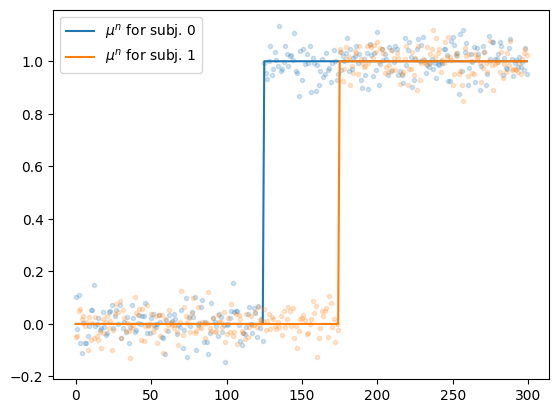

In [8]:
for i in range(2):
    l = plt.plot(true_subj_means[i], alpha=1, label=f'$\mu^n$ for subj. {i}')[0]
    plt.plot(subj_obs[i], '.', color=l.get_color(), alpha=0.2)
plt.legend()

## Sample conditional distribution for each subject

The effective observations for each subject are the weighted average of its observations and the global mean.

In [9]:
key = jr.PRNGKey(0)
subj_means = gibbs_sample_subject_means(
    key, subj_obs, sigmasq_obs, true_global_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)

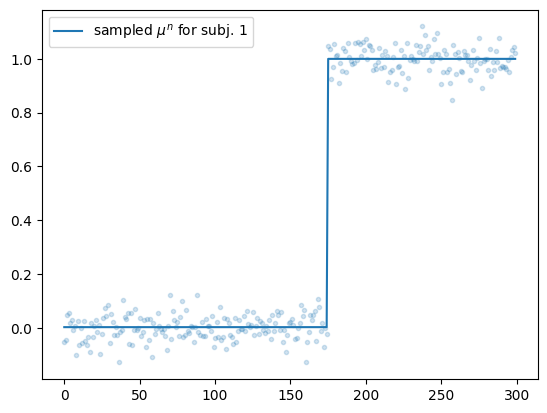

In [10]:
for i in range(1, 2):
    l = plt.plot(subj_means[i], alpha=1, label=f'sampled $\mu^n$ for subj. {i}')[0]
    plt.plot(subj_obs[i], '.', color=l.get_color(), alpha=0.2)
plt.legend()

[524.14417]
[620.42847]


Array([False], dtype=bool)

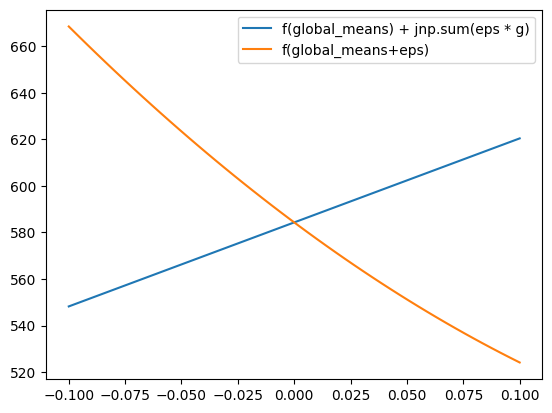

In [57]:
def _calculate_f_g(global_means_):
    """"""
    log_normalizer, _, _, expected_subj_means = core.gaussian_cp_smoother(
        global_means_, hazard_rates, mu_pri, sigmasq_pri, sigmasq_subj
    )
    f = 1 / sigmasq_subj * jnp.sum((subj_means - global_means_) ** 2) - log_normalizer
    g = (
        1 / sigmasq_subj * jnp.sum(subj_means - expected_subj_means, axis=0)
    )  # sum over subjects
    return f, g

eps= 1e-4
# global_means = jnp.average(subj_obs, axis=0)
global_means = jnp.ones((num_timesteps, num_features)) * 0.2

f_s = []
fv_s = []
eps_s = jnp.linspace(-0.1, 0.1)
for i, eps in enumerate(eps_s):
    f, g = _calculate_f_g(global_means)
    fv, gv = _calculate_f_g(global_means + eps)
    f_s.append(f + jnp.sum(eps * g))
    fv_s.append(fv)

plt.plot(eps_s, f_s, label='f(global_means) + jnp.sum(eps * g)')
plt.plot(eps_s, fv_s, label='f(global_means+eps)')
plt.legend()

print(fv)
print(f + jnp.sum(eps * g))
f == (f + jnp.sum(eps * g))

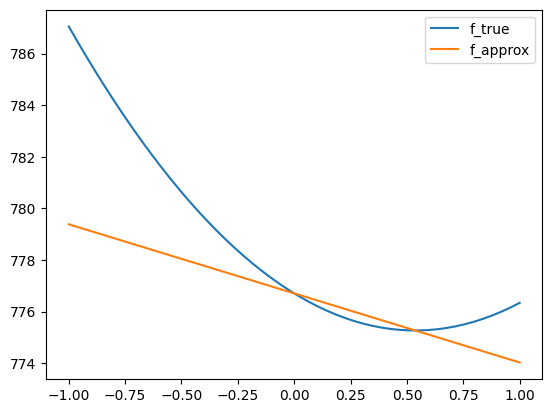

In [59]:
this_key = jr.key(seed=42)
x0 = jnp.zeros((num_timesteps, num_features))
u = jr.normal(this_key, (num_timesteps, num_features))
u /= jnp.sqrt(jnp.sum(u**2))

eps = jnp.linspace(-1, 1)
fx0, gx0 = _calculate_f_g(x0)
f_true = vmap(lambda e: _calculate_f_g(x0 + e * u)[0])(eps)
f_approx = vmap(lambda e: fx0 + jnp.sum(e * u * -gx0))(eps)
plt.plot(eps, f_true, label='f_true')
plt.plot(eps, f_approx, label='f_approx')
plt.legend()

In [60]:
from bayes_ca import prox_grad

stepsize = 0.8
# global_means = jnp.average(subj_obs, axis=0)
global_means = jnp.ones((num_timesteps, num_features)) * 0.2
global_means, g = prox_grad.line_search(
    stepsize,
    global_means,
    subj_means,
    mu_pri,
    sigmasq_pri,
    sigmasq_subj,
    hazard_rates,
)

## Compute gradient with respect to the global mean

In [ ]:
# stepsize = 0.1
# global_means = jnp.average(subj_obs, axis=0)

# # with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):
# for i in progress_bar(range(100000)):
#     global_means, g = prox_update_global_mean(
#         stepsize, global_means, subj_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)

(-0.2, 1.2)

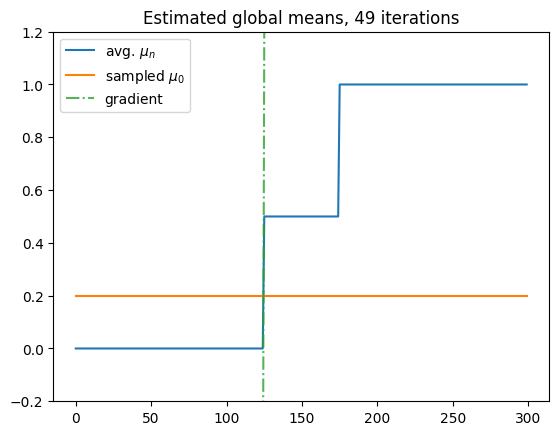

In [61]:
plt.plot(true_subj_means.mean(axis=0), label='avg. $\mu_n$')
plt.plot(global_means, label='sampled $\mu_0$')
plt.plot(g, ls='-.', label='gradient', alpha=0.8)
# plt.axhline(0.5, color='k', ls=':', label='initialization')
plt.title(f'Estimated global means, {i} iterations')
plt.legend()
plt.ylim(-0.2, 1.2)

## Put both steps together

In [ ]:
@jit
def step(key,
         stepsize,
         subj_obs, 
         sigmasq_obs, 
         global_means, 
         sigmasq_subj, 
         mu_pri, 
         sigmasq_pri, 
         hazard_rates):
    
    # Sample new subject means
    subj_means = gibbs_sample_subject_means(
        key, subj_obs, sigmasq_obs, global_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)
    
    # Update the global mean
    global_means, g = core.backtracking_lsearch(stepsize, global_means, subj_means, sigmasq_subj,
                                                hazard_rates, mu_pri, sigmasq_pri)
    
    return global_means, subj_means, g

In [ ]:
key = jr.PRNGKey(0)
stepsize = 0.1
global_means = jnp.average(subj_obs, axis=0)

for itr in progress_bar(range(100)):
    this_key, key = jr.split(key)
    global_means, subj_means, g = step(
        this_key,
        stepsize,
        subj_obs, 
        sigmasq_obs, 
        global_means, 
        sigmasq_subj, 
        mu_pri, 
        sigmasq_pri, 
        hazard_rates
    )

In [ ]:
plt.plot(true_global_means, label='true $\mu_0$')
plt.plot(global_means, label='sampled $\mu_0$')
plt.plot(g, ls='-.', label='gradient', alpha=0.8)
# plt.axhline(0.5, color='k', ls=':', label='initialization')
plt.title(f'Estimated global means, {i} iterations')
plt.legend()
plt.ylim(-0.2, 1.2)

In [ ]:
l = plt.plot(subj_means[1], label=f'sampled $\mu^n$ for subj. 1')[0]
plt.plot(subj_obs[1], 'o', color=l.get_color(), alpha=0.1, lw=3)
plt.plot(global_means, label='sampled $\mu^0$')
plt.plot(g, '-.', label='gradient', alpha=0.8)
plt.legend()
plt.ylim(-0.2, 1.2)